# We know *where aircraft flew.*  What were their acoustic properties on the ground?

Current issues: https://github.com/dbetchkal/NMSIM-Python/issues

In [1]:
# this module contains a list of libraries, functions, and global constants used in this workbook
# import everything using wildcard (*)
from NMSIM_DENA_Flight_Tracks import *

#### <font color="gray">Reference *[Optional]:*</font> using `iyore` what sites were deployed concurrent to GPS data collection?
 <font color="gray">Use this cell if you need a refresher on the available sites.</font>

In [ ]:
# find Denali sites from 2019, 2020
np.unique([e.site for e in archive.dataDir(unit="DENA", year=["2019", "2020"])])

## Step 1: Select GPS points, convert to NMSIM trajectories *(.trj)*
**Also create an NMSIM *.sit* file!** <br><br>
Given
>NPS monitoring site <br>
>year <br>
>how far away are you interested in vehicle motion (kilometers) <br>

#### <font color=salmon size=4>You must edit lines 3 - 5.</font>

DENAK5Z52015: 599542, 7047550 - UTM zone 5
	microphone height 4.20 feet.

	Shapefile containing 25km radius buffer has been written!


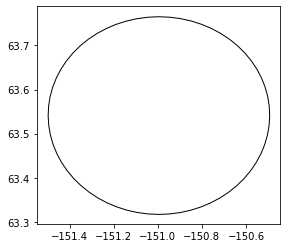


	Record begins 2015-06-04 and ends 2015-09-01 



TypeError: 'CRS' object is not subscriptable

In [2]:
# =============  EDIT  =====================================================
#   DEFINE THE PROJECT DIRECTORY and YEAR
project_dir = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\DENAK5Z5"
year = 2015
how_far_away = 25 # km
# ==========================================================================

# extract the site name from the project directory path
site = project_dir[-4:]

# create a table of all the flights
tracks = tracks_within(archive, site, year, 
                       search_within_km = how_far_away, 
                       aircraft_specs=False, 
                       NMSIM_proj_dir = project_dir,
                       decouple=True)

# which N-Numbers were observed on this record?
tracks.registration.unique()

## Step 2: Run the models in NMSIM
#### <font color=salmon>Repeat for each N-Number of interest, *then* proceed to the next cell.</font>

In [ ]:
# ============= EDIT ===================================================

# FAA registry for aircraft of interest
Focal_NNumber = "N74PS"

# ======================================================================

# NMSIM program directiory
NMSIMpath = os.path.dirname(os.path.dirname(project_dir))

# lookup for appropriate NMSIM source file
source_map = {"N8888": NMSIMpath + os.sep + "Sources\MiscellaneousSources\omni.src",
              "N709M": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src",
             "N570AE": NMSIMpath + os.sep + "Sources\AirTourHelicopterSources\AS350.src",
              "N74PS": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N619CH": NMSIMpath + os.sep +  "Sources\AirTourFixedWingSources\C207.src",
             "N72309": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N72395": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N473YC": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N21HY":  NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src"}


# run the NMSIM model
NMSIM_create_tis(project_dir, source_map[Focal_NNumber], Nnumber=Focal_NNumber)

## Step 3: Pair NMSIM results to NPS acoustic measurements

In [ ]:
# NMSIM isn't always successful - we want to iterate only through files that WERE created
trj_and_tis = pair_trj_to_tis_results(project_dir)

# (whether or not to show diagnostic plots; default: False)
diagnostic = False

for trj, tis in trj_and_tis:
    
    print(trj, "\n", tis)
    
    runName = os.path.basename(trj)[:-4]
    
    # read just the header of the trajectory
    with open(trj) as lines:
        head = [next(lines) for x in range(12)]

    # here's the string containing the starting time (to the second!)
    dateString = head[-1][-24:-5]

    # convert to a datetime object
    startdate = dt.datetime.strptime(dateString, "%Y-%m-%d %H:%M:%S")

    print("now working on run:", runName)
    
    try:
        # this is the theoretical 1/3rd octave band trace
        theory = tis_resampler(tis, startdate)
        
    except:
        print("tis", tis)
        print("produced a ValueError related to nan values in the .tis file")
    
    
    # compare and save results
    event_SPL = NVSPL_to_match_tis(archive, project_dir, 
                                   startdate, theory, trj, 
                                   unit="DENA", site=site, year=int(startdate.year),
                                   utc_offset=-8, pad_length=5)
    
    # show diagnostic plots
    if(diagnostic == True):
        
        plt.figure(figsize=(14, 3))
        plt.plot(theory.index, theory["A"], zorder=5, ls="", marker="o", ms=2)
        plt.legend(loc="best")
        plt.show()